<h1 id="Contents">Contents<a href="#Contents"></a></h1>
        <ol>
        <li><a class="" href="#Imports">Imports</a></li>
<li><a class="" href="#Defining-the-Data-Directory-and-Result-Directory">Defining the Data Directory and Result Directory</a></li>
<li><a class="" href="#Initializing-the-Classes">Initializing the Classes</a></li>
<li><a class="" href="#Extracting-Information">Extracting Information</a></li>
<ol><li><a class="" href="#Determining-the-Region-of-Interest">Determining the Region of Interest</a></li>
<li><a class="" href="#Reiniatilizing-the-Classes">Reiniatilizing the Classes</a></li>
<li><a class="" href="#Setting-the-Reference-Image">Setting the Reference Image</a></li>
<li><a class="" href="#Extracting-Center-Related-Information">Extracting Center Related Information</a></li>
<li><a class="" href="#Some-Preliminary-Analysis">Some Preliminary Analysis</a></li>
<ol><li><a class="" href="#None-Values">None Values</a></li>
<li><a class="" href="#Sample-Images">Sample Images</a></li>
</ol><li><a class="" href="#Extracting-Objectives">Extracting Objectives</a></li>
<ol><li><a class="" href="#Getting-Frame-Information">Getting Frame Information</a></li>
<li><a class="" href="#Getting-Angle-and-Velocity">Getting Angle and Velocity</a></li>
<li><a class="" href="#The-Additional-Information">The Additional Information</a></li>
<li><a class="" href="#Adding-the-Additional-Information">Adding the Additional Information</a></li>
<li><a class="" href="#Save-the-DataFrame">Save the DataFrame</a></li>
</ol>

# Imports

In [38]:
from extract_center import CenterExtracter
from run import Run
from misc_tools import Plotter, Smoother
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Defining the Data Directory and Result Directory

In [39]:
sequence = "h21_short"
DATA_DIR = '../../data/extracted_images/' + sequence
RESULT_DIR = '../../data/results/' + sequence

# Initializing the Classes

In [40]:
run = Run(DATA_DIR, RESULT_DIR)
ce = CenterExtracter()

# Extracting Information

## Determining the *Region of Interest*

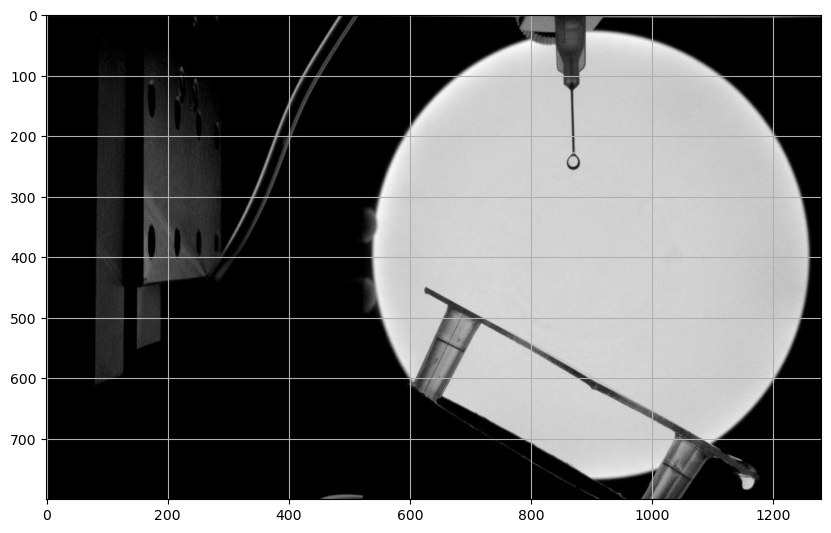

In [41]:
images = run.get_images()
img_1 = ce._read_image(images[0])
ce._show_image(img_1)

In [42]:
region_of_interset = (800, 200, 1200, 750)

## Reiniatilizing the Classes

In [43]:
run = Run(DATA_DIR, RESULT_DIR, region = region_of_interset)

## Setting the Reference Image

In [44]:
run._set_ref_image(-10)

## Extracting Center Related Information

In [45]:
df = run.all_points(crop_included=True, binary=True, verbose=False, num_images=None, raise_error=False)

Getting list of images...
Extracting data from images...


Extracting data from images: 100%|██████████| 143/143 [00:03<00:00, 43.13it/s]

Saving to csv...
Done!


## Some Preliminary Analysis

### None Values

In [46]:
df.isna().sum()

id        0
x        25
y        25
r1       25
r2       25
theta    25
dtype: int64

In [47]:
none_values = df.isna().sum()["x"]
total_frames = len(df)
unrealistic = len(df[((df["r1"]+df["r2"])/2>20)|((df["r1"]+df["r2"])/2<5)])

In [48]:
df = pd.read_csv(RESULT_DIR + '/centers_using_ap.csv')

### Sample Images

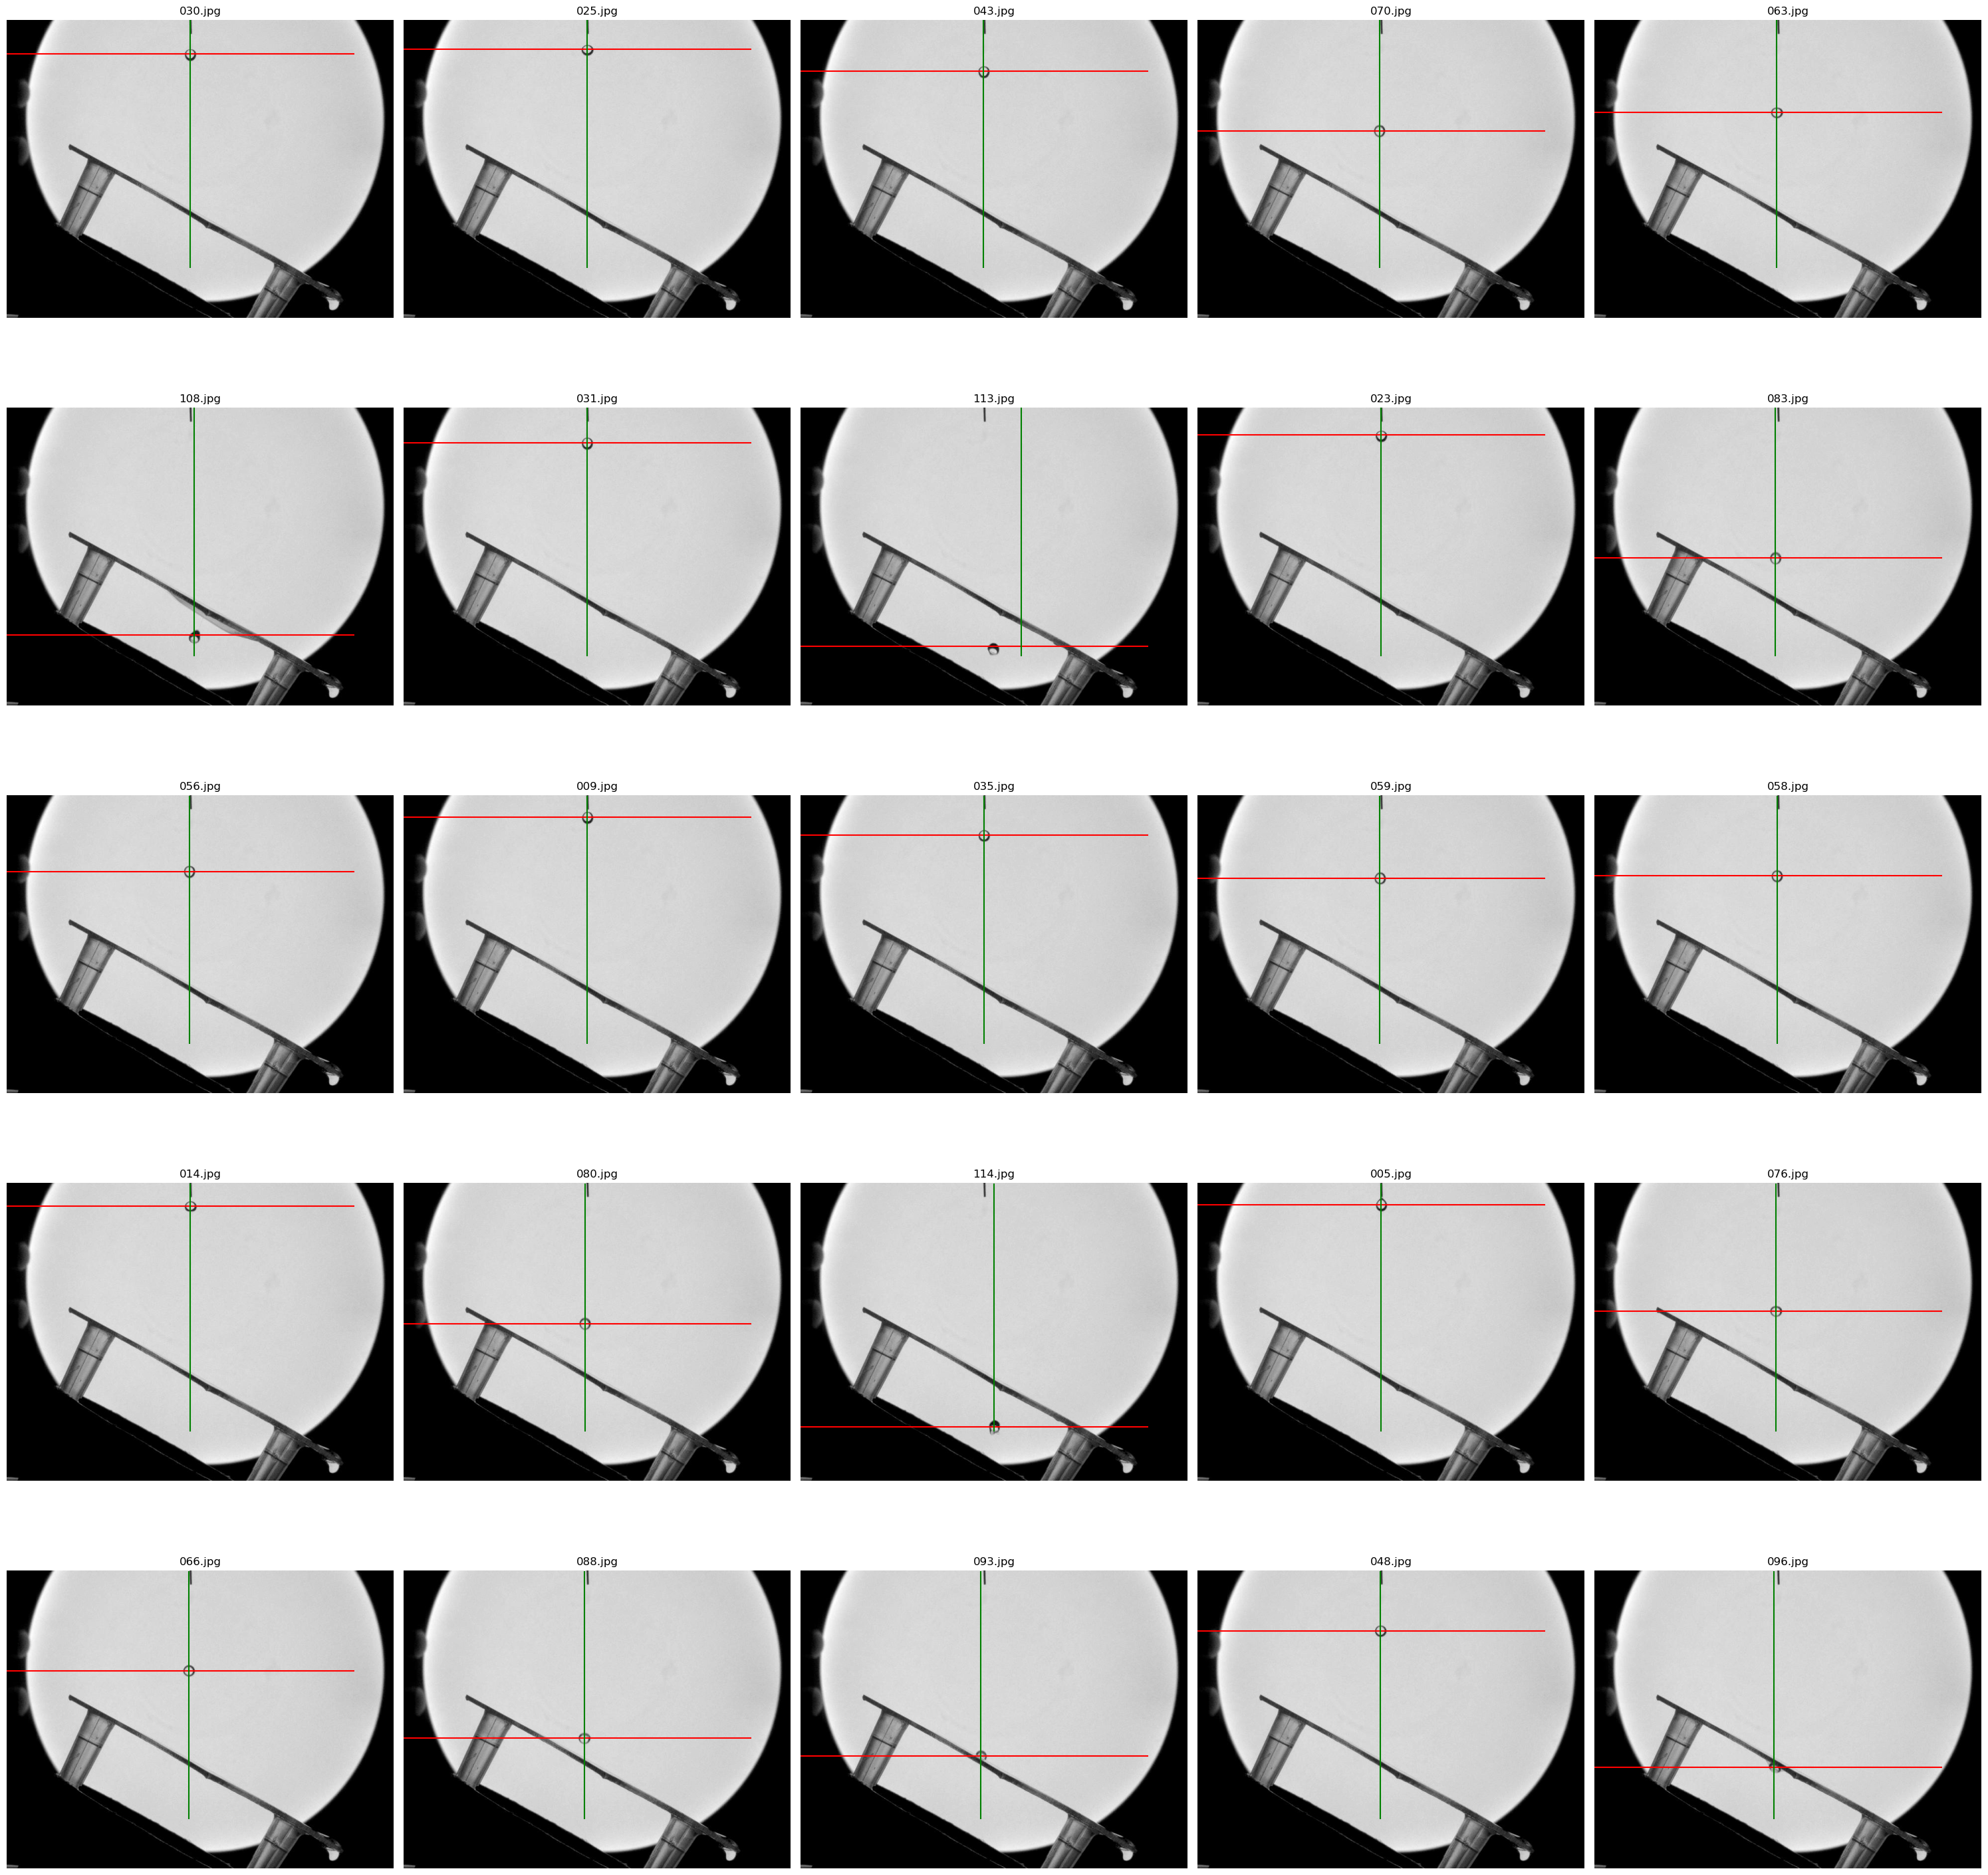

In [49]:
p = Plotter(df, RESULT_DIR)
p.get_samples(25, file_name = f"{sequence}_samples.png")

## Extracting Objectives

### Getting Frame Information

In [50]:
info_dict = {
    "first_frame": 1,
    "last_frame": 2,
    "contact_frame": 3,
    "leave_frame": 4,
    "angle": 5,
}

In [51]:
def update_info(file, info, line_num = 4):
    with open(file, "r") as f:
        texts = f.readlines()
    line = texts[line_num]
    value = line.split(":")[1].strip()
    if value == "":
        line = line.split(":")[0] + ": " + info + "\n"
        texts[line_num] = line
    else:
        texts[line_num] = line
    with open(file, "w") as f:
        f.writelines(texts)
    return texts[line_num]
# leave_frame = df[df["y"] == df["y"].max()]["id"].values[-1].split("/")[-1]
last_frame = df.iloc[-10]["id"].split("/")[-1]
# update_info(f"{DATA_DIR}.txt", leave_frame, line_num = 4)
update_info(f"{DATA_DIR}.txt", last_frame, line_num = 2)

'### Last Frame ID: 021.jpg\n'

In [52]:
def get_info(file):
    information = {}
    with open(file, "r") as f:
        texts = f.readlines()
    for key, value in info_dict.items():
        line = texts[value]
        info = line.split(":")[1].strip()
        information[key] = info
    return information

information = get_info(f"{DATA_DIR}.txt")

In [53]:
first_frame = DATA_DIR + "/" +information["first_frame"]
last_frame = DATA_DIR + "/" +information["last_frame"]
contact_frame = DATA_DIR + "/" +information["contact_frame"]
angle = information["angle"]
leave_frame = DATA_DIR + "/" +information["leave_frame"]

In [54]:
first_frame, last_frame

('../../data/extracted_images/h21_short/',
 '../../data/extracted_images/h21_short/021.jpg')

### Getting Angle and Velocity

In [55]:
s = Smoother(df)
df_s = s.smoothen(remove_noise = False)
df_c = df[df.notna()]

In [56]:
df_s["vx"] = df_s["x"].diff(7)/7
df_s["vy"] = df_s["y"].diff(7)/7
df_s.dropna(inplace=True)
df_s["vx"] = df_s["vx"].astype(float)
df_s["vy"] = df_s["vy"].astype(float)
df_s["v"] = np.sqrt(df_s["vx"]**2 + df_s["vy"]**2)

df_c["vx"] = df_c["x"].diff(7)/7
df_c["vy"] = df_c["y"].diff(7)/7
df_c.dropna(inplace=True)
df_c["vx"] = df_c["vx"].astype(float)
df_c["vy"] = df_c["vy"].astype(float)
df_c["v"] = np.sqrt(df_c["vx"]**2 + df_c["vy"]**2)

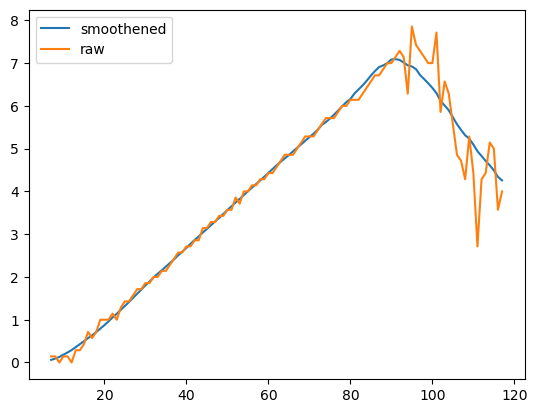

In [57]:
plt.plot(df_s["vy"], label = "smoothened")
plt.plot(df_c["vy"], label = "raw")
plt.legend();

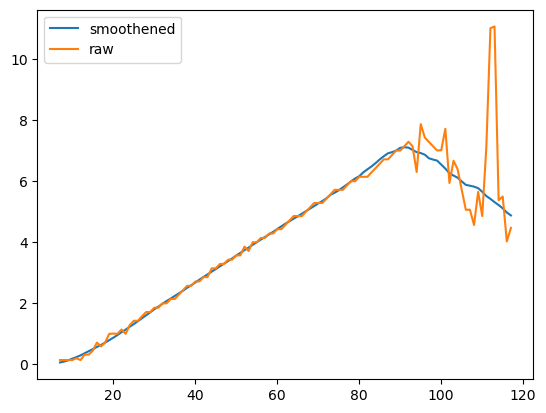

In [58]:
plt.plot(df_s["v"], label = "smoothened")
plt.plot(df_c["v"], label = "raw")
plt.legend();

In [59]:
def get_angle(row):
    vx = row["vx"]
    vy = -row["vy"]
    if vx == 0 and vy == 0:
        return 0
    elif vx==0:
        return 90
    else:
        return np.arctan(vy/vx)*180/np.pi

In [60]:
df_s["angle"] = df_s.apply(get_angle, axis=1)
df_c["angle"] = df_c.apply(get_angle, axis=1)

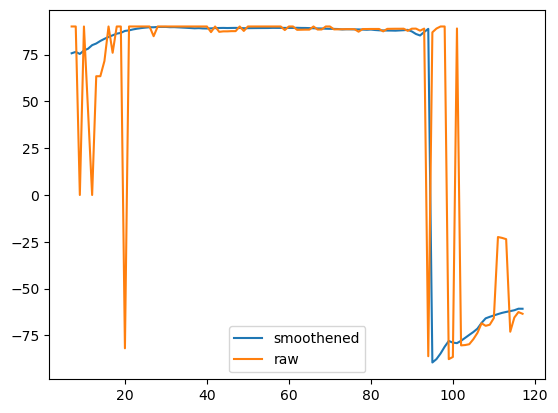

In [61]:
plt.plot(df_s["angle"], label = "smoothened")
plt.plot(df_c["angle"], label = "raw")
plt.legend();

### The Additional Information

In [62]:
df_c[df_c["id"] == contact_frame].T

92
id     ../../data/extracted_images/h21_short/092.jpg
x                                              862.0
y                                              567.0
r1                                              10.0
r2                                              11.0
theta                                      41.825919
vx                                         -0.285714
vy                                          7.285714
v                                           7.291314
angle                                      87.754257

In [63]:
df_c[df_c["id"] == leave_frame].T

104
id     ../../data/extracted_images/h21_short/104.jpg
x                                              871.0
y                                              646.0
r1                                              16.0
r2                                              10.0
theta                                     100.267614
vx                                          1.142857
vy                                          6.285714
v                                           6.388766
angle                                     -79.695154

In [64]:
df_s[df_s["id"] == contact_frame].T

92
id     ../../data/extracted_images/h21_short/092.jpg
x                                         859.226508
y                                         566.796748
r1                                          9.658537
r2                                          4.933258
theta                                      55.195259
r                                           6.942522
vx                                         -0.594927
vy                                          7.075251
v                                           7.100219
angle                                       85.19355

In [65]:
df_s[df_s["id"] == leave_frame].T

104
id     ../../data/extracted_images/h21_short/104.jpg
x                                          877.27491
y                                         641.144073
r1                                          11.12025
r2                                         13.515031
theta                                      66.968139
r                                          12.065797
vx                                           1.61297
vy                                          5.898414
v                                           6.114979
angle                                     -74.705904

In [66]:
reg = re.compile(r"\d{3}")
contact_frame_num = int(reg.findall(contact_frame)[0])
leave_frame_num = int(reg.findall(leave_frame)[0])
contact_frame_num, leave_frame_num

(92, 104)

In [67]:
angle_at_contact_frame_s = df_s.loc[contact_frame_num]["angle"]
angle_at_leave_frame_s = df_s.loc[leave_frame_num]["angle"]

angle_at_contact_frame_c = df_c.loc[contact_frame_num]["angle"]
angle_at_leave_frame_c = df_c.loc[leave_frame_num]["angle"]


if angle_at_contact_frame_s<0:
    angle_at_contact_frame_s = 180 + angle_at_contact_frame_s

if angle_at_contact_frame_c<0:
    angle_at_contact_frame_c = 180 + angle_at_contact_frame_c


angle_at_contact_frame_c, angle_at_contact_frame_s, angle_at_leave_frame_c, angle_at_leave_frame_s

(87.75425743410493, 85.19355015819777, -79.69515353123397, -74.70590425000522)

In [68]:
velocity_at_leave_frame_s = df_s.loc[leave_frame_num]["v"]
velocity_at_contact_frame_s = df_s.loc[contact_frame_num]["v"]
velocity_at_leave_frame_s, velocity_at_contact_frame_s

(6.114978891429254, 7.100218913773893)

In [69]:
velocity_at_leave_frame_c = df_c.loc[leave_frame_num]["v"]
velocity_at_contact_frame_c = df_c.loc[contact_frame_num]["v"]
velocity_at_leave_frame_c, velocity_at_contact_frame_c

(6.388765649999399, 7.2913143743856255)

In [70]:
x_velocity_at_leave_frame_s = df_s.loc[leave_frame_num]["vx"]
x_velocity_at_contact_frame_s = df_s.loc[contact_frame_num]["vx"]
y_velocity_at_leave_frame_s = df_s.loc[leave_frame_num]["vy"]
y_velocity_at_contact_frame_s = df_s.loc[contact_frame_num]["vy"]
print(x_velocity_at_leave_frame_s, x_velocity_at_contact_frame_s, y_velocity_at_leave_frame_s, y_velocity_at_contact_frame_s)

x_velocity_at_leave_frame_c = df_c.loc[leave_frame_num]["vx"]
x_velocity_at_contact_frame_c = df_c.loc[contact_frame_num]["vx"]
y_velocity_at_leave_frame_c = df_c.loc[leave_frame_num]["vy"]
y_velocity_at_contact_frame_c = df_c.loc[contact_frame_num]["vy"]
print(x_velocity_at_leave_frame_c, x_velocity_at_contact_frame_c, y_velocity_at_leave_frame_c, y_velocity_at_contact_frame_c)

1.6129703157496513 -0.5949274775139851 5.898414499095144 7.075250519947076
1.1428571428571428 -0.2857142857142857 6.285714285714286 7.285714285714286


### Adding the Additional Information

In [71]:
pattern = "***"
information = f"""\n{pattern*20}
### TOTAL FRAMES: {total_frames}
### NONE FRAMES: {none_values}
### UNREALISTIC FRAMES: {unrealistic}

{pattern*20}
USING THE SMOOTHENED DATA
AT CONTACT FRAME:
### ANGLE: {np.round(-90+angle_at_contact_frame_s+float(angle), 2)}
### VELOCITY: {np.round(velocity_at_contact_frame_s, 2)}
### X VELOCITY: {np.round(x_velocity_at_contact_frame_s, 2)}
### Y VELOCITY: {np.round(y_velocity_at_contact_frame_s, 2)}

AT LEAVE FRAME:
### ANGLE: {np.round(angle_at_leave_frame_s, 2)}
### VELOCITY: {np.round(velocity_at_leave_frame_s, 2)}
### X VELOCITY: {np.round(x_velocity_at_leave_frame_s, 2)}
### Y VELOCITY: {np.round(y_velocity_at_leave_frame_s, 2)}

{pattern*20}
USING THE RAW DATA
AT CONTACT FRAME:
### ANGLE: {np.round(-90+angle_at_contact_frame_c+float(angle), 2)}
### VELOCITY: {np.round(velocity_at_contact_frame_c, 2)}
### X VELOCITY: {np.round(x_velocity_at_contact_frame_c, 2)}
### Y VELOCITY: {np.round(y_velocity_at_contact_frame_c, 2)}

AT LEAVE FRAME:
### ANGLE: {np.round(angle_at_leave_frame_c, 2)}
### VELOCITY: {np.round(velocity_at_leave_frame_c, 2)}
### X VELOCITY: {np.round(x_velocity_at_leave_frame_c, 2)}
### Y VELOCITY: {np.round(y_velocity_at_leave_frame_c, 2)}
{pattern*20}"""
print(information)


************************************************************
### TOTAL FRAMES: 143
### NONE FRAMES: 25
### UNREALISTIC FRAMES: 4

************************************************************
USING THE SMOOTHENED DATA
AT CONTACT FRAME:
### ANGLE: 24.19
### VELOCITY: 7.1
### X VELOCITY: -0.59
### Y VELOCITY: 7.08

AT LEAVE FRAME:
### ANGLE: -74.71
### VELOCITY: 6.11
### X VELOCITY: 1.61
### Y VELOCITY: 5.9

************************************************************
USING THE RAW DATA
AT CONTACT FRAME:
### ANGLE: 26.75
### VELOCITY: 7.29
### X VELOCITY: -0.29
### Y VELOCITY: 7.29

AT LEAVE FRAME:
### ANGLE: -79.7
### VELOCITY: 6.39
### X VELOCITY: 1.14
### Y VELOCITY: 6.29
************************************************************


First, remove anything between the asterisks.

In [72]:
with open(DATA_DIR+".txt", "r") as f:
    texts = f.readlines()
text = "".join(texts[:6])
print(text)
all_text = text+information

### h21_short.tif
### First Frame ID: 
### Last Frame ID: 021.jpg
### Contact Frame ID: 092.jpg
### Leave Frame ID: 104.jpg
### Angle: 29



In [73]:
with open(RESULT_DIR +"/info.txt", "w") as f:
    f.writelines(all_text)

### Save the DataFrame

In [74]:
df_s.to_csv(RESULT_DIR + f"/{sequence}_smoothened.csv", index=False)